# Prediction with LSTM model

In [1]:
# importing libraries and moduls
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.losses import mean_squared_error
from keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
TecDAX_data = pd.read_csv("TECDAX.csv")                      # load TecDAX from 2009-05-01 till 2019-05-01
TecDAX_data["Date"] = pd.to_datetime(TecDAX_data["Date"])    # convert 'Date' from object to datetime

In [3]:
TecDAX_data.set_index("Date", inplace=True)                  # set index       
TecDAX_data.info()
TecDAX_data.sort_index(inplace=True)                         # sort index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2532 entries, 2009-05-04 to 2019-04-30
Data columns (total 6 columns):
Open         2532 non-null float64
High         2532 non-null float64
Low          2532 non-null float64
Close        2532 non-null float64
Adj Close    2532 non-null float64
Volume       2532 non-null int64
dtypes: float64(5), int64(1)
memory usage: 138.5 KB


In [4]:
# extract adjusted closing prices (variable to predict)
TecDAX_close = TecDAX_data["Adj Close"]
TecDAX_close = TecDAX_close.values.reshape(len(TecDAX_close),1)

# split data into train and test data
train_size = int(len(TecDAX_close) * 0.7)
test_size  = len(TecDAX_close) - train_size

TecDAX_train, TecDAX_test = TecDAX_close[0:train_size,:], TecDAX_close[train_size:len(TecDAX_close),:]

print("Training observations: ", len(TecDAX_train))
print("Testing observations:  ", len(TecDAX_test))

Training observations:  1772
Testing observations:   760


In [5]:
# normalize data
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(TecDAX_train)
test_set_scaled     = sc.fit_transform(TecDAX_train)

In [6]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []

for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [7]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1198/1198 [==============================] - 14s 11ms/step - loss: 0.0083
Epoch 2/100
1198/1198 [==============================] - 10s 9ms/step - loss: 0.0013
Epoch 3/100
1198/1198 [==============================] - 10s 8ms/step - loss: 0.0012
Epoch 4/100
1198/1198 [==============================] - 10s 8ms/step - loss: 9.9990e-04
Epoch 5/100
1198/1198 [==============================] - 10s 8ms/step - loss: 9.8710e-04
Epoch 6/100
1198/1198 [==============================] - 10s 8ms/step - loss: 0.0011
Epoch 7/100
1198/1198 [==============================] - 10s 8ms/step - loss: 9.1817e-04
Epoch 8/100
1198/1198 [==============================] - 10s 8ms/step - loss: 9.0085e-04
Epoch 9/100
1198/1198 [==============================] - 10s 8ms/ste

In [8]:
# Getting the predicted stock price of 2017
dataset_total = pd.concat((pd.Series(TecDAX_train[:,0]), pd.Series(TecDAX_test[:,0])), axis = 0)
inputs = dataset_total[len(dataset_total) - len(TecDAX_test) - 60:]
inputs = inputs.values.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


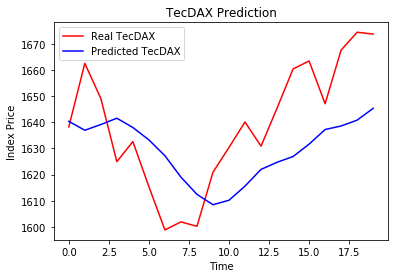

In [9]:
# Visualising the results
plt.plot(TecDAX_test[0:20,:], color = 'red', label = 'Real TecDAX')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TecDAX')
plt.title('TecDAX Prediction')
plt.xlabel('Time')
plt.ylabel('Index Price')
plt.legend()
plt.show()